In [38]:
import sys
import os

# Add the simulations/mcpy directory to the Python path
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '../../simulations')))

import numpy as np
import pandas as pd

from sklearn.preprocessing import PolynomialFeatures

import ivfunctions_nested 
import simulations.dgps_nested as dgps
import matplotlib.pyplot as plt
from nnpiv.linear import sparse_l1vsl1, sparse_ridge_l1vsl1, sparse2_l1vsl1, sparse2_ridge_l1vsl1
 

In [39]:
fn_number = 0
tau_fn = dgps.get_tau_fn(fn_number)

In [40]:
A, D, B, C, Y, tau_fn = dgps.get_data(1000, 10, 10, tau_fn, 2)


B_test = np.zeros((1000, B.shape[1]))
B_test += np.median(B, axis=0, keepdims=True)
B_test[:, 0] = np.linspace(np.percentile(B[:, 0], 5), np.percentile(B[:, 0], 95), 1000)

B_test = B_test[np.argsort(B_test[:, 0])]
true_fn = tau_fn(B_test)


In [41]:
def nested_npivfit(A, B, C, D, Y, B_test, model, fitargs=None, deg=2):
    
    B1_test = B_test
    Y = Y
    A1 = A
    B1 = B
    A2 = D
    B2 = C

    trans = PolynomialFeatures(degree=deg, include_bias=False)
    #First stage
    if fitargs is not None:
        model.fit(A2, A1, Y, **fitargs)
    else:
        model.fit(trans.fit_transform(A2), trans.fit_transform(A1), Y)
    bridge_fs = model.predict(trans.fit_transform(A1))
    bridge_fs = bridge_fs.reshape(A1.shape[:1] + Y.shape[1:])

    #Second stage
    if fitargs is not None:
        model.fit(B2, B1, bridge_fs, **fitargs)
    else:
        model.fit(trans.fit_transform(B2), trans.fit_transform(B1), bridge_fs)
    
    y_pred = model.predict(trans.fit_transform(B1_test))
    return y_pred.reshape(B1_test.shape[:1] + Y.shape[1:])



In [42]:
splin_1 = sparse_l1vsl1(B=10, lambda_theta=.1,
                                             eta_theta=.1,
                                             eta_w=.1,
                                             n_iter=10000, tol=.0001, sparsity=None)
splin_1_pred = nested_npivfit(A, B, C, D, Y, B_test, model=splin_1, deg=3)


In [43]:
splin_2 = sparse_ridge_l1vsl1(B=10, lambda_theta=.025,
                                             eta_theta=.1,
                                             eta_w=.1,
                                             n_iter=20000, tol=.0001, sparsity=None)
splin_2_pred = nested_npivfit(A, B, C, D, Y, B_test, model=splin_2, deg=3)


In [44]:
trans = PolynomialFeatures(degree=3, include_bias=False)


splin3 = sparse2_l1vsl1(mu=0.1, V1=10, V2=10,
                 eta_alpha='auto', eta_w1='auto', eta_beta='auto', eta_w2='auto',
                 n_iter=10000, tol=.0001/2, sparsity=None, fit_intercept=True)
splin3_pred = splin3.fit(trans.fit_transform(A), trans.fit_transform(B),
                         trans.fit_transform(C), trans.fit_transform(D), 
                         Y).predict(trans.fit_transform(B_test))
                         


In [45]:
splin4 = sparse2_ridge_l1vsl1(mu=0.025, V1=10, V2=10,
                 eta_alpha='auto', eta_w1='auto', eta_beta='auto', eta_w2='auto',
                 n_iter=20000, tol=.0001/2, sparsity=None, fit_intercept=True)
splin4_pred = splin4.fit(trans.fit_transform(A), trans.fit_transform(B),
                         trans.fit_transform(C), trans.fit_transform(D), 
                         Y).predict(trans.fit_transform(B_test))

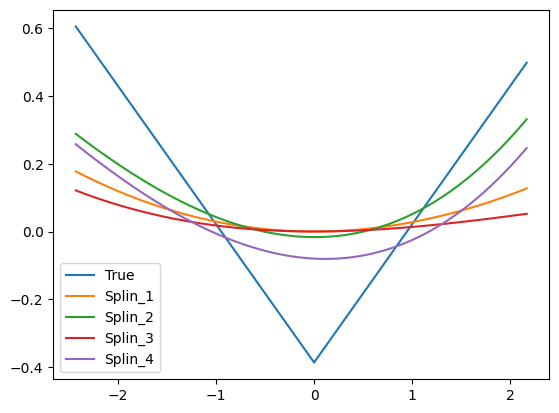

In [46]:
plt.plot(B_test[:, 0], true_fn, label='True')
plt.plot(B_test[:, 0], splin_1_pred, label='Splin_1')
plt.plot(B_test[:, 0], splin_2_pred, label='Splin_2')
plt.plot(B_test[:, 0], splin3_pred, label='Splin_3')
plt.plot(B_test[:, 0], splin4_pred, label='Splin_4')
plt.legend()
